**< NEURAL NETWORK >**

In [0]:
"""
    By Talendar (Gabriel Nogueira)
"""

import numpy as np
import random
import time
import datetime


class NeuralNetwork:
    """
    """

    def __init__(self, layers_size=None, cost_type="mse", layers_activation="sigmoid", logs_path="./logs"):
        """
        Constructor
        :param layers_size: list containing the sizes of the layers. The layers activation functions will be the default one.
        """
        self.cost_type = cost_type
        self.layers = []
        self.logs_path = logs_path

        if layers_size is not None:
            self.layers.append(NeuralLayer(layers_size[0], input_count=0, activation="input_layer"))
            for s in layers_size[1:]:
                input_count = self.layers[-1].size
                self.layers.append(NeuralLayer(s, input_count, layers_activation))


    def add_layer(self, size, activation="sigmoid"):
        """
        :param size:
        :param activation:
        :return:
        """
        try:
            self.layers.append(NeuralLayer(size[0], input_count=0, activation="input_layer"))
            for s in size[1:]:
                input_count = self.layers[-1].size
                self.layers.append(NeuralLayer(s, input_count, activation))

        except TypeError:
            if len(self.layers) == 0:
                self.layers.append(NeuralLayer(size, input_count=0, activation="input_layer"))
            else:
                input_count = self.layers[-1].size
                self.layers.append(NeuralLayer(size, input_count, activation))


    def predict(self, x):
        """
        Wrapper for the feedforward function that uses the network's current weights and bias.

        :param x: column vector containing the features of the sample. If an out of shape numpy array is fed, this function
        won't work properly due to errors in matrix multiplications.
        :return:
        """
        weights = [l.weights for l in self.layers[1:]]
        bias = [l.bias for l in self.layers[1:]]

        return self.feedforward(weights, bias, x)


    def feedforward(self, weights, bias, x):
        """
        Feedforward.

        :param weights: list with the weights matrix for each layer (excluding the first layer).
        :param bias: list with the bias vector for each layer (excluding the first layer).
        :param x: column vector containing the features of the sample. If an out of shape numpy array is fed, this function
        won't work properly due to errors in matrix multiplications.
        :return: a vector (numpy array) containing the output of each neuron of the output layer.
        """
        a = self.colvector(x)
        for i, l in enumerate(self.layers[1:]):
            w, b = weights[i], bias[i]
            a = l.activate(np.dot(w, a) + b)

        return a


    def costfunc_unit(self, h, y, derivative=False):

        """
        :param x:
        :param y:
        :param derivative:
        :return:
        """
        if self.cost_type.lower() == "mse":
            if not derivative:
                return ((h - y) ** 2) / 2
            else:
                return h - y

        raise NameError("Cost function of the type \"%s\" is not defined!" % str(self.cost_type))


    def costfunc(self, data):
        """
        :param training_set:
        :param labels:
        :return:
        """
        p_cols = 1
        try:
            p_cols = len(data[0][0])
        except TypeError:
            pass

        l_cols = 1
        try:
            l_cols = len(data[0][1])
        except TypeError:
            pass

        m = len(data)
        predictions = np.zeros((m, p_cols))
        labels = np.zeros((m, l_cols))

        for i in range(m):
            h, y = data[i]
            predictions[i] = h.transpose()
            labels[i] = y.transpose()

        if self.cost_type.lower() == "mse":
            loss = np.sum((predictions - labels) ** 2) / (2 * m)
            return loss

        raise NameError("Cost function of the type \"%s\" is not defined!" % str(self.cost_type))


    def colvector(self, v):
        """
        Turn a numpy array into a column vector.
        :param v:
        :return:
        """
        try:
            v.shape = (len(v), 1)
        except Exception:
            pass

        return v


    def generate_mini_batches(self, training_data, labels, mini_batch_size):
        """
        :param training_data:
        :param mini_batch_size_pc:
        :return:
        """
        m = len(training_data)
        indexes = [n for n in range(m)]
        random.shuffle(indexes)

        mini_batches_x = [training_data[indexes[k:(k + mini_batch_size)]] for k in range(0, m, mini_batch_size)]
        mini_batches_y = [labels[indexes[k:(k + mini_batch_size)]] for k in range(0, m, mini_batch_size)]

        return mini_batches_x, mini_batches_y


    def backpropagation(self, x, y):
        """
        :param x:
        :param y:
        :return: a tuple containing, respectively: the gradient of the cost function with respect to the weights; the
        gradient of the cost function with respect to the bias; the prediction (activation result of the output layer)
        of the model for the given sample.
        """
        grad_w = [np.zeros(l.weights.shape) for l in self.layers[1:]]
        grad_b = [np.zeros(l.bias.shape) for l in self.layers[1:]]

        # FORWARD PASS
        activations = [self.colvector(x)]
        zs = []  # note that the input layer is not considered! So this list will have a size num_layers - 1

        for l in self.layers[1:]:  # excluding the input layer from the iteration
            w, b = l.weights, l.bias
            a = self.colvector(activations[-1])
            z = np.dot(w, a) + b

            zs.append(z)
            activations.append(l.activate(z))

        # BACKWARD PASS
        delta = self.costfunc_unit(activations[-1], y, derivative=True) * self.layers[-1].activate(zs[-1], derivative=True)  # initial delta is delta_L (delta for the output layer)

        # gradients with respect to the output layer
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].transpose())

        # gradients with respect to the hidden layers
        for l in range((len(self.layers) - 2), 0, -1):
            w_lp1, delta_lp1 = self.layers[l + 1].weights, delta
            a_der = self.layers[l].activate(zs[l - 1], derivative=True)  # l - 1 because zs doesnt have the input layer!

            delta = np.dot(w_lp1.transpose(), delta) * a_der
            grad_b[l - 1] = delta
            grad_w[l - 1] = np.dot(delta, activations[l - 1].transpose())

        return grad_w, grad_b, activations[-1]


    def params_to_row(self, weights, bias):
        """

        :param weights:
        :param bias:
        :return:
        """
        flat_params = np.concatenate((weights[0].flatten(), bias[0].flatten()))
        for w, b in zip(weights[1:], bias[1:]):
            temp = np.concatenate((w.flatten(), b.flatten()))
            flat_params = np.concatenate((flat_params, temp))

        return flat_params


    def params_to_matrix(self, flat_params):
        """

        :param flat_params:
        :return:
        """
        weights, bias = [], []
        consumed = 0

        for l in self.layers[1:]:
            rows_w, cols_w = l.weights.shape
            total_w = rows_w * cols_w
            w = flat_params[consumed : consumed + total_w]
            w.shape = (rows_w, cols_w)
            weights.append(w)
            consumed += total_w

            rows_b, cols_b = l.bias.shape
            total_b = rows_b * cols_b
            b = flat_params[consumed: consumed + total_b]
            b.shape = (rows_b, cols_b)
            bias.append(b)
            consumed += total_b

        return weights, bias


    def compute_gradient_numerically(self, data_x, data_y):
        """
        Compute the gradient of the cost function numerically. To be used in gradient checking only.

        :param data_x:
        :param data_y:
        :return:
        """
        e = 1e-4
        flat_params = self.params_to_row( [l.weights for l in self.layers[1:]] , [l.bias for l in self.layers[1:]] )
        num_grad = np.zeros(flat_params.shape)
        pertub = np.zeros(flat_params.shape)

        for i in range(0, len(flat_params)):
            pertub[i] = e
            inc_params = self.params_to_matrix(flat_params + pertub)
            dec_params = self.params_to_matrix(flat_params - pertub)

            inc_predictions = [(self.feedforward(*inc_params, x), y) for x, y in zip(data_x, data_y)]
            dec_predictions = [(self.feedforward(*dec_params, x), y) for x, y in zip(data_x, data_y)]

            J = self.costfunc
            num_grad[i] += (J(inc_predictions) - J(dec_predictions)) / (2*e)
            pertub[i] = 0

        return num_grad


    def gradient_checking(self, bp_grad_w, bp_grad_b, data_x, data_y):
        """

        :param bp_grad_w:
        :param bp_grad_b:
        :return:
        """
        bp_grad = self.params_to_row(bp_grad_w, bp_grad_b)
        num_grad = self.compute_gradient_numerically(data_x, data_y)

        relative_error = np.linalg.norm(bp_grad - num_grad) / np.linalg.norm(bp_grad + num_grad)

        with open(self.logs_path + "/log_gradient_checking.txt", "a") as file:
            file.write("Relative error: %.4e\n\n" % relative_error)



    def regularization_term(self, m, method, factor, derivative=False, w=None):
        """

        :param m:
        :param method:
        :param factor:
        :param derivative:
        :param w:
        :return:
        """
        if method.lower() == "l2":
            if derivative:
                return w * factor / m
            else:
                w_sum = 0
                for l in self.layers:
                    w_sum += np.sum(np.square(l.weights))

                return w_sum * factor / (2 * m)

        raise NameError("Regularization method of the type \"%s\" is not defined!" % str(method))


    def sgd(self, training_data, labels, epochs, learning_rate, mini_batch_size,
            reg_method=None, reg_factor=0, verbose=True, gradient_checking=False):
        """
        Fit the network's parameters to the training data using Stochastic Gradient Descent.

        :param training_data: numpy ndarray containing, in each row, all the samples of the training set (each row is a
        vector of the features representing one of the samples).
        :param labels: column vector, in the form of a numpy array of the appropriate shape, containing the labels with
        respect to the training set samples.
        :param epochs: number of iterations to be ran by the algorithm.
        :param mini_batch_size: size of the mini batches of samples to be used in each iteration.
        :return:
        """
        # Prep
        if gradient_checking:
            with open(self.logs_path + "/log_gradient_checking.txt", "w") as file:
                file.write("< Started at: " + str(datetime.datetime.now()) + " >\n\n")
        starting_time = time.time()
        all_costs = []

        # SGD
        for e in range(epochs):
            mini_batches = self.generate_mini_batches(training_data, labels, mini_batch_size)
            predictions = []

            for mini_batch_x, mini_batch_y in zip(mini_batches[0], mini_batches[1]):

                # gradient of the cost function (considering the current batch) with respect to the weights and bias
                grad_w = [np.zeros(l.weights.shape) for l in self.layers[1:]]
                grad_b = [np.zeros(l.bias.shape) for l in self.layers[1:]]
                for x, y in zip(mini_batch_x, mini_batch_y):
                    x, y = self.colvector(x), self.colvector(y)
                    grad_w_variation, grad_b_variation, h = self.backpropagation(x, y)
                    predictions.append((h, y))  # save the values of the predictions and its associated label

                    grad_w = [cur + var for cur, var in zip(grad_w, grad_w_variation)]
                    grad_b = [cur + var for cur, var in zip(grad_b, grad_b_variation)]

                m = len(mini_batch_y)
                grad_w = [w/m for w in grad_w]
                grad_b = [b/m for b in grad_b]

                # gradient checking (this won't work if you grad check after updating the params!)
                if gradient_checking:
                    self.gradient_checking(grad_w, grad_b, mini_batch_x, mini_batch_y)

                # updating weights and bias
                for i, l in enumerate(self.layers[1:]):
                    gw, gb = grad_w[i], grad_b[i]

                    l.bias -= (learning_rate * gb)
                    reg_term = 0 if reg_method is None else self.regularization_term(m, reg_method,
                                                                    reg_factor, derivative=True, w=l.weights)
                    l.weights -= learning_rate * (gw + reg_term)

            # cost function history
            all_costs.append(self.costfunc(predictions))

            # print status
            if verbose:
                pc = (e + 1) / epochs
                bar = "|" + "#" * int(70 * pc) + "_" * int(70 * (1 - pc)) + "|"

                elapsed_time = time.time() - starting_time
                remaining_time = elapsed_time * (epochs - e + 1) / (e + 1)
                m, s = divmod(remaining_time, 60)
                h, m = divmod(m, 60)

                try:
                    # noinspection PyUnresolvedReferences
                    from IPython.display import clear_output  # required to clean the output when using notebooks
                    clear_output(wait=True)
                except ImportError:
                    print("\n" * 50)

                print("Epoch: %d/%d  %s  ETA: %02dh %02dmin %02ds"
                      "\nTotal loss/cost: %.6f"
                      % ((e + 1), epochs, bar, h, m, s, all_costs[-1]))

        return all_costs


    def save_params(self, file_name="./data/params.txt"):
        """
        :param file_name:
        :return:
        """
        file = open(file_name, "w")

        for i in range(1, len(self.layers)):
            l = self.layers[i]
            for W in l.weights:
                for w in W:
                    to_write = str(w).replace("[", "").replace("]", "")
                    file.write(to_write + " ")
                file.write("\n")

            for b in l.bias:
                to_write = str(b).replace("[", "").replace("]", "")
                file.write(to_write + " ")
            file.write("\n")

        file.close()


    def load_params(self, file_name="./data/params.txt"):
        """
        :param file_name:
        :return:
        """
        file = open(file_name, "r")
        for l in self.layers[1:]:

            for i in range(len(l.weights)):
                raw = file.readline().split()
                for j in range(len(l.weights[i])):
                    l.weights[i][j] = float(raw[j])

            raw = file.readline().split()
            for i in range(len(l.bias)):
                l.bias[i] = float(raw[i])
        file.close()



class NeuralLayer:
    """
    """

    def __init__(self, size, input_count, activation="sigmoid"):
        self.size = size
        self.input_count = input_count
        self.activation = activation

        if activation.lower() == "input_layer":
            self.weights, self.bias = None, None
        else:
            self.weights = np.random.uniform(low=-1, high=1, size=(size, input_count))
            self.bias = np.random.uniform(low=-1, high=1, size=(size, 1))


    def activate(self, z, derivative=False):
        """
        :param z:
        :return:
        """
        if self.activation.lower() == "input_layer":
            raise ValueError("Tried to activate the neurons from the input layer!")

        if self.activation.lower() == "sigmoid":
            return 1 / (1 + np.exp(-z)) if not derivative else (self.activate(z) * (1 - self.activate(z)))

        if self.activation.lower() == "relu":
            return np.maximum(z, 0) if not derivative else np.ceil(np.clip(z, 0, 1))

        if self.activation.lower() == "linear":
            return z if not derivative else 1

        raise NameError("Activation function of the type \"%s\" is not defined!" % str(self.activation))



def gradient_checking_sample():
    """

    :return:
    """
    m = 32
    net = NeuralNetwork([1, 10, 10, 10, 1], layers_activation="sigmoid")
    net.layers[-1].activation = "linear"

    training_data = np.array([x for x in np.random.rand(m)*100])
    training_labels = np.array([2*x for x in training_data])

    # BACKPROP
    bp_grad_w = [np.zeros(l.weights.shape) for l in net.layers[1:]]
    bp_grad_b = [np.zeros(l.bias.shape) for l in net.layers[1:]]
    for x, y in zip(training_data, training_labels):
        x, y = net.colvector(x), net.colvector(y)
        gw_var, gb_var, h = net.backpropagation(x, y)

        bp_grad_w = [cur + var for cur, var in zip(bp_grad_w, gw_var)]
        bp_grad_b = [cur + var for cur, var in zip(bp_grad_b, gb_var)]

    bp_grad_w = [w / m for w in bp_grad_w]
    bp_grad_b = [b / m for b in bp_grad_b]
    bp_grad = net.params_to_row(bp_grad_w, bp_grad_b)

    # NUM GRAD
    num_grad = net.compute_gradient_numerically(training_data, training_labels)

    # COMPARE
    for bp, num in zip(bp_grad, num_grad):
        print("%f  |  %f" % (bp, num))

    relative_error = np.linalg.norm(bp_grad - num_grad) / np.linalg.norm(bp_grad + num_grad)
    print("\nRelative error: %.2e" % relative_error)



**< DIGIT CLASSIFIER >**

In [0]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


def vectorize_labels(labels, vector_size):
    """

    :param y:
    :return:
    """
    m = len(labels)
    vectorized = np.zeros((m, vector_size))

    if vector_size > 1:
        vectorized = np.zeros((m, vector_size))

        for i in range(0, m):
            v = np.zeros(vector_size)
            v[labels[i]] = 1
            vectorized[i] = v
    else:
        labels.shape = (m, 1)
        vectorized = labels

    return vectorized


def visualize_image(image_array, width, height):
    """

    :param image_array:
    :param width:
    :param height:
    :return:
    """
    %matplotlib inline
    
    img_array = image_array[:]
    img_array.shape = (width, height)
    
    plt.imshow(img_array, cmap='gray', vmin=0, vmax=255)


def validate(net, test_set, test_set_labels):
    """

    :param net
    :param test_set:
    :param test_set_labels:
    :return:
    """
    hits = 0
    for x, y in zip(test_set, test_set_labels):
        h = np.argmax(net.predict(x))
        hits += 1 if h == y else 0

    return hits / len(test_set)

Epoch: 500/500  |######################################################################|  ETA: 00h 00min 09s
Total loss/cost: 0.054948

Accuracy: 92.10%



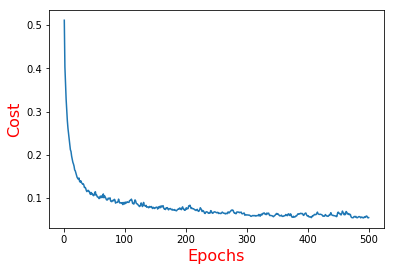

In [11]:
# TRAINING
data = pd.read_csv("./sample_data/mnist_train_small.csv")
training_data, training_labels = data.iloc[:, 1:].values, vectorize_labels(data.iloc[:, 0].values, 10)

net = NeuralNetwork([784, 32, 32, 10], logs_path="./")
epochs = 500
costs = net.sgd(training_data, training_labels, epochs, learning_rate=0.1, 
        mini_batch_size=32, gradient_checking=False)
net.save_params("./params_digits_classifier.npz")

# VALIDATING
data2 = pd.read_csv("./sample_data/mnist_test.csv")
test_data, test_labels = data2.iloc[:, 1:].values, data2.iloc[:, 0].values

accuracy = validate(net, test_data, test_labels)
print("\nAccuracy: %.2f%%\n" % (accuracy*100))

# plotting cost function
%matplotlib inline
plt.plot(range(1, epochs+1), costs)
plt.xlabel("Epochs", fontsize=16, color="red")
plt.ylabel("Cost", fontsize=16, color="red")
plt.show()



   Prediction: 3  |  Label: 3




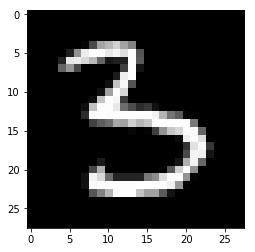

In [17]:
# VISUAL TESTING
import random

index = random.randint(0, len(test_data) - 1)
x, y = test_data[index], test_labels[index]
visualize_image(x, 28, 28)

np.seterr(all="ignore")
h = np.argmax(net.predict(x))
np.seterr(all="warn")

print("\n\n   Prediction: %d  |  Label: %d\n\n" % (h, y))

**< HOUSE PRICING >**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("./sample_data/california_housing_train.csv")
training_data, training_labels = data.drop("median_house_value", 1).values, data["median_house_value"].values

# normalizing the training data
mean, std = np.mean(training_data), np.std(training_data)
#training_data = (training_data - mean) / std

# training the network
net = NeuralNetwork(layers_size=[8, 32, 32, 1], layers_activation="sigmoid")
net.layers[-1].activation = "linear"
net.sgd(training_data, training_labels, epochs=100, learning_rate=0.01, 
        mini_batch_size=32, reg_method="l2", reg_factor=0.1)

# validating
data2 = pd.read_csv("./sample_data/california_housing_test.csv")
testing_data, testing_labels = data2.drop("median_house_value", 1).values, data2["median_house_value"].values
#testing_data = (testing_data - mean) / std

accepted_error_pc = 0.12
hits = 0
errors = []

for x, y in zip(testing_data, testing_labels):
    h = net.predict(x)
    errors.append(abs(h - y))
    if y*(1 + accepted_error_pc) >= h >= y*(1 - accepted_error_pc):
        hits += 1
        
print("Accuracy (considering an error up to %.2f%%): %.2f%%" % (accepted_error_pc*100, (hits/len(testing_data))*100))
print("Mean error: %.2f  |  Errors std: %.2f" % (sum(errors)/len(testing_data), np.std(errors)))

Epoch: 100/100  |######################################################################|  ETA: 00h 00min 03s
Total loss/cost: 6744803229.791312
Accuracy (considering an error up to 12.00%): 15.03%
Mean error: 89730.23  |  Errors std: 68865.00


**< ESSAY SCORING >**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import pandas as pd
import numpy as np


def vectorize_labels(labels, size):
    grade_interval = 1000 / (size - 1)
    m = len(labels)
    vectorized = np.zeros((m, size))
    
    for i in range(0, m):
        y = labels[i]
        index = int(y / grade_interval)
        vectorized[i][index] = 1
    
    return vectorized
        

# preparing data
root_path = 'gdrive/My Drive/ml_data' 
data = pd.read_excel(root_path + "/essays.xlsx", usecols="Z, AA:AM")
data = data[data["Nota"] != 0]

data_train = data.sample(frac=0.8)
data_test = data.drop(data_train.index)

training_data, training_labels = data_train.drop("Nota", 1).values, data_train["Nota"].values
testing_data, testing_labels = data_test.drop("Nota", 1).values, data_test["Nota"].values

# normalization
mean, std = np.mean(training_data), np.std(training_data)
training_data = (training_data - mean) / std
testing_data = (testing_data - mean) / std

In [0]:
# TREATING SCORING AS A CLASSIFICATION PROBLEM

num_classes = 10
v_training_labels = vectorize_labels(training_labels, num_classes)

net = NeuralNetwork([13, 16, num_classes], layers_activation="sigmoid")
net.sgd(training_data, v_training_labels, epochs=1000, learning_rate=0.01, 
        mini_batch_size=32, reg_method="l2", reg_factor=0.001)

# validating
hits = 0
for x, y in zip(testing_data, testing_labels):
    grade_interval = 1000 / num_classes
    y_class = int(y / grade_interval)
    
    h_class = np.argmax(net.predict(x))
    hits += 1 if h_class == y_class else 0
    
print("Accuracy: %.2f%%" % ( 100*hits / len(testing_data) ))

Epoch: 1000/1000  |######################################################################|  ETA: 00h 00min 00s
Total loss/cost: 0.381499
Accuracy: 20.10%


In [0]:
# TREATING SCORING AS A REGRESSION PROBLEM

net = NeuralNetwork([13, 32, 32, 32, 1], layers_activation="sigmoid")
net.layers[-1].activation = "linear"
net.sgd(training_data, training_labels, epochs=10000, learning_rate=0.00005, 
        mini_batch_size=32, reg_method="l2", reg_factor=3)
net.save_params(root_path + "/essay_regression_params.npz")

# validating
accepted_error = 100
errors = []
hits = 0

for x, y in zip(testing_data, testing_labels):
    h = net.predict(x)
    errors.append(abs(h - y))
    hits += 1 if errors[-1] <= accepted_error else 0
    
print("Accuracy (considering an error up to %.2f points): %.2f%%" % ( accepted_error, 100*hits / len(testing_data) ))
print("Mean error: %.2f  |  Errors std: %.2f" % ( sum(errors) / len(testing_data), np.std(errors) ))

Epoch: 10000/10000  |######################################################################|  ETA: 00h 00min 00s
Total loss/cost: 4528.718352
Accuracy (considering an error up to 100.00 points): 67.46%
Mean error: 85.44  |  Errors std: 66.60
